In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
from numpy.lib.format import open_memmap
from scripts.data import *

In [3]:
# load et data
data_path_ec07 = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
data_path      = './../data/ETFinalCutSample/'
results_path   = './../results/'

# path check
check_path = './../data/sanity_check/'

df_wk = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_dg.csv')) 
df_ff = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff_dg.csv'))
df_tp = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp_dg.csv'))

videos_df = {'Diary': df_wk, 'Fractals': df_ff, 'Present': df_tp}

# load data
videos_data = load_video_data()
trials_data = load_trials_data()
pheno_data = load_metadata()

# Check folders and files

In [4]:
pd.read_csv(os.path.join(check_path,'missingFF.csv')).head()

,subj_id
0,NDARAB055BPR
1,NDARAB348EWR
2,NDARAB793GL3
3,NDARAC857HDB
4,NDARAD224CRB


In [16]:
missing_folders  = []
missing_csv_vid  = []
missing_metadata = []
results          = []
for idx, fold_subj in pd.read_csv(os.path.join(check_path,'missingFF.csv')).iterrows():
    if fold_subj[0] not in os.listdir(data_path_ec07):
        missing_folders.append(fold_subj)
        

In [17]:
len(missing_folders)

764

In [20]:
missing = []
for fold_subj in os.listdir(data_path):
    if fold_subj not in os.listdir(data_path_ec07):
        missing.append(fold_subj)

In [21]:
len(os.listdir(data_path_ec07)), len(os.listdir(data_path)), len(missing)

(994, 764, 764)

In [22]:
a = os.listdir(data_path_ec07) + os.listdir(data_path)

In [26]:
pd.Series(a).value_counts()

NDARMN376BMF    1
NDARLE417FRX    1
NDARAV189JGX    1
NDARTW501ZKN    1
NDAREN151YXN    1
               ..
NDAREH905REB    1
NDARGE536BGD    1
NDARVU883NDE    1
NDARWW480TU2    1
NDARJX458DVE    1
Length: 1758, dtype: int64

# join data frames

In [5]:
import os
import numpy as np
import pandas as pd
import pickle
from numpy.lib.format import open_memmap
from scripts.data import *
import glob

In [3]:
results_path = './../results/revised/FF/'
results_vn = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(results_path, 'results_nss_ff_vn_*'))])
results_fn = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(results_path, 'results_nss_ff_fn_*'))])
results = results_vn.merge(right=results_fn[['ID', 'FIX_idx', 'NSS', 'NSS_MEAN']], on=['ID','FIX_idx'], suffixes=('_vn', '_fg'))
results.to_csv(os.path.join(results_path, 'results_nss_ff.csv'), index=False)

In [3]:
results.columns

Index(['ID', 'FIX_idx', 'NSS_vn', 'NSS_MEAN_vn', 'FIX_IN_VID', 'VIDEO_NAME',
       'ET_FILE', 'FRAME_idx', 'NSS_fg', 'NSS_MEAN_fg'],
      dtype='object')

In [10]:
results.drop_duplicates('ID').shape

(940, 10)

In [4]:
results.isna().sum()

ID             0
FIX_idx        0
NSS_vn         0
NSS_MEAN_vn    0
FIX_IN_VID     0
VIDEO_NAME     0
ET_FILE        0
FRAME_idx      0
NSS_fg         0
NSS_MEAN_fg    0
dtype: int64

<AxesSubplot:>

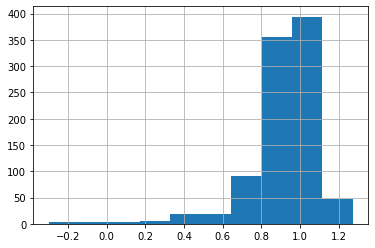

In [9]:
results.drop_duplicates('ID').NSS_MEAN_fg.hist()

# Profile NSS score

In [4]:
import cv2
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from pandarallel import pandarallel
from scipy.stats import multivariate_normal, entropy
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.main import *
from scripts.saliency_metrics import *

In [6]:
# data path where each subject forlder is 
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'
trials_data = load_trials_data()
videos_data = load_video_data()
metadata    = load_metadata()

In [7]:
def create_saliency_matrix(video_path, saliency_path ='../videos_sal/vinet'):
    folder = video_path #videos_data.loc[video].Video[:-4]
    maps = []
    for img in sorted(os.listdir(os.path.join(saliency_path, folder))):
        if img[0] == '.':
            continue
        maps.append(cv2.imread(os.path.join(saliency_path, folder, img), cv2.IMREAD_GRAYSCALE))
    return np.stack(maps, axis=2)

def calculate_metric_subject(df_et, fold_subj, 
                             trials_data,
                             videos_data,
                             vid_name,
                             saliency,
                             sal_mean,
                             sal_std,
                             metric,
                             trial_init=None,
                             frame_dur=None,
                             frame_timest=None):
    
    if not frame_dur:
        frame_dur = (videos_data.loc[vid_name].FramesTimestamps[1])
    if not trial_init:
        trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    if not frame_timest:
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    
    df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init, sdt_correction = False)
    # drop fixations after video ended
    df_fix = df_fix[df_fix['start_time']//frame_dur < saliency.shape[-1]]
    print(fold_subj)
    if flag==-1:
        pass
    elif metric =='CC':
        score = calculate_CC_apply(df_fix, saliency)
    elif metric=='NSS':
        score = calculate_NSS(df_fix, saliency, sal_mean, sal_std, frame_dur)
    else:
        print('Metric not implemented')
        pass
    
    mean_score = np.mean(np.array(score))

    return df_fix, score, mean_score, flag

def calculate_metric_chunks(data_path,
                            trials_data,
                            videos_data,
                            n_chunks:int,
                            chunk_i:int,
                            vid_name = 'Diary',
                            saliency = None,
                            metric = 'NSS',
                            saliency_path = ''):
    
    trials_data_vid = trials_data[trials_data.VideoName==vid_name]
    frame_dur = (videos_data.loc[vid_name].FramesTimestamps[1])
    vid = {'Diary': 'WK', 'Fractals': 'FF', 'Present': 'TP'}

    # vid_saliency   = videos_data.loc[vid_name, 'VideoSaliency']
    # vid_saliency_p = videos_data.loc[vid_name, 'VideoSalPercentils']
    # saliency       = open_memmap('Videos_sal/cb/'+vid_saliency)
    # sal_perc       = np.load('./cache/'+vid_saliency_p)
    
    if saliency is None:
        #saliency = open_memmap(os.path.join(saliency_path, videos_data.loc[vid_name, 'VideoSaliency']))
        saliency = create_saliency_matrix(videos_data.loc[vid_name].Video[:-4], saliency_path=saliency_path)
        
    missing_folders  = []
    video_not_seen   = []
    missing_metadata = []
    results          = []
    error_list       = []

    n_subj     = len(trials_data_vid)
    subj_count = 0
    
    # precalculate saliency metrics
    sal_mean = saliency.mean(axis=(0,1))
    sal_std = np.zeros(saliency.shape[-1])
    for i in range(saliency.shape[-1]):
        sal_std[i] = saliency[:,:,i].std()
    
    # calculate chunk
    aux = sorted(os.listdir(data_path))
    corte = int(len(aux)//n_chunks)
    if n_chunks == 0:
        iter_list = aux
    elif chunk_i == n_chunks-1:
        iter_list = aux[chunk_i * corte:]
    else:
        iter_list = aux[chunk_i * corte:(chunk_i+1)*corte]
    
    for fold_subj in tqdm(iter_list):
        
        if fold_subj not in list(metadata['ID'].unique()):
            missing_metadata.append(fold_subj)
            continue
        
        csv_files    = os.listdir(data_path+fold_subj)
        csv_vid_file = [f for f in csv_files if vid[vid_name] in f]
        if len(csv_vid_file) ==0:
            video_not_seen.append(fold_subj)
            continue

        et_file      = os.path.join(data_path, fold_subj, csv_vid_file[0])
        df_et        = pd.read_csv(et_file)
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
        
        try:
            trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
        except:
            missing_metadata.append([fold_subj, vid_name])
            continue
            
        # calculate metric
        try:
            df_fix, score, mean_score, flag = calculate_metric_subject(df_et, trials_data, videos_data, vid_name, saliency, sal_mean, sal_std,
                                                                       metric, trial_init, frame_dur, frame_timest)
            results.append((fold_subj,  df_fix.index, score, mean_score, len(df_fix), flag, vid_name, et_file))
        except:
            error_list.append(fold_subj)
        
    return results, {'missing_folders': missing_folders, 'missing_metadata': missing_metadata, 'video_not_seen': video_not_seen}

In [8]:
vid_name = 'Present'
metric = 'NSS'
saliency = create_saliency_matrix(videos_data.loc[vid_name].Video[:-4], saliency_path='./../videos_sal/vinet/')

In [9]:
sal_mean = saliency.mean(axis=(0,1))
sal_std = np.zeros(saliency.shape[-1])
for i in range(saliency.shape[-1]):
    sal_std[i] = saliency[:,:,i].std()

In [10]:
fold_subj = 'NDARAB793GL3' 
et_file = 'NDARAB793GL3/NDARAB793GL3_Video-TP_ET_right.csv'
df_et   = pd.read_csv(os.path.join(data_path,et_file))

In [11]:
frame_dur = (videos_data.loc[vid_name].FramesTimestamps[1])
trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    
df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init, sdt_correction = False)

In [12]:
for row_fix in df_fix.itertuples():
    print(row_fix.x)
    break

[354.72, 354.78, 358.02, 357.97, 357.41, 359.81, 356.28, 357.42, 357.67, 359.2, 357.42, 358.56, 362.03, 360.77, 360.77, 361.16, 361.58, 361.52]


In [23]:
res = calculate_metric_subject(df_et, fold_subj, trials_data, videos_data, vid_name, saliency, sal_mean, sal_std,
                               metric, trial_init=None, frame_dur=None, frame_timest=None)

NDARAB793GL3


In [20]:
res[2]

3.582639613999171

In [10]:
import cProfile

In [13]:
cProfile.run('res = calculate_metric_subject(df_et, fold_subj, trials_data, videos_data, vid_name, saliency, metric, trial_init=None, frame_dur=None, frame_timest=None)')

NDARAB793GL3
         955610 function calls (955264 primitive calls) in 340.592 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       14    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(append)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_equal)
       12    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        8    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(can_cast)
       35    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
       11    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(delete)
       

# Chequeo de como armar las tablas como lo toma el archivo de R

Previo a reunion del 18/5

- script que arme una tabla para cada frame, uno para cada escena
- script que tome la tabla y consiga los resultados en R y los guarde de alguna manera

In [1]:
import os
import numpy as np
import pandas as pd
from scripts.utils import *
from scripts.data import *
import seaborn as sns

In [2]:
VIDEO = 'WK'
results_path = '../results/'
file = 'results_nss_diary.csv'
VIDEO_NAME = 'Diary'
NFRAMES = 2817

# load videos data
videos_data = load_video_data()

# read NSS files
df = pd.read_csv(os.path.join(results_path, VIDEO, file))
df_means = df.groupby('ID')[['NSS_vn','NSS_fg']].mean()

# compare both NSS files
df_r = pd.read_csv(os.path.join('R', 'FinalTableH3bWK.csv'),sep=';')
df_compare = pd.merge(df_r, df_means, on='ID', how='inner')
df_compare.head()[['ID','NSS_fg_x', 'NSS_fg_y', 'NSS_vn_x', 'NSS_vn_y']]

,ID,NSS_fg_x,NSS_fg_y,NSS_vn_x,NSS_vn_y
0,NDARAA948VFH,0.801732,0.786114,4.912928,4.866635
1,NDARAB055BPR,0.590099,0.583332,4.005577,4.001258
2,NDARAB348EWR,0.349040,0.342468,0.153688,0.163958
3,NDARAB793GL3,0.594015,0.585165,4.759204,4.713752
4,NDARAC349YUC,0.677634,0.663874,3.767241,3.729957


In [32]:
# filter subjects
ids_data = df_r.ID.unique()

# create timeseries table - align NSS files
ts_vn = create_timeseries_matrix(df[df.ID.isin(ids_data)].reset_index(), 
                                              metric_val='NSS_vn',
                                              nframes = NFRAMES)

ts_fg = create_timeseries_matrix(df[df.ID.isin(ids_data)].reset_index(), 
                                              metric_val='NSS_fg',
                                              nframes = NFRAMES)

# check save path
results_dir = './results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

video_results_dir = os.path.join(results_dir, VIDEO)
if not os.path.exists(video_results_dir):
    os.mkdir(video_results_dir)

In [51]:
# filter timeseries table (subset of frames)
for fr in range(0, NFRAMES, 5):
    # exclude tables of unneded frames fr.isin(frame_list)
    if True:
        # format data for R
        aux = df_r.drop(columns=['NSS_vn', 'NSS_fg'])
        #print(aux.shape)
        vn_col = ts_vn.T.iloc[:,fr].rename('NSS_vn')
        aux = pd.merge(aux, vn_col, left_on='ID', right_index=True, how='inner')
        # TODO: perdi unos 60 sujetos seguramente en la funcion de create timeseries matrix
        #print(aux.shape)
        fg_col = ts_fg.T.iloc[:,fr].rename('NSS_fg')
        aux = pd.merge(aux, fg_col, left_on='ID', right_index=True, how='inner')
        # save data in R format for each frame with separator ';'
        aux.to_csv(os.path.join(video_results_dir, 'table_{}_{}.csv'.format(VIDEO_NAME, fr)), index=False, sep=';')

## Crear tablas pero para cada escena

In [47]:
#saliency_models_nss = ['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']
saliency_models_nss = ['NSS_vn', 'NSS_fg']
palette =  dict(zip(saliency_models_nss, sns.color_palette(n_colors=4)))

In [59]:
# primero agregar escenas
df = pd.read_csv(os.path.join(results_path, VIDEO, file))
scenes_data =  pd.read_csv('../videos_data/Diary/Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv', header=1)
saliency_models = saliency_models_nss

# probando la función a manopla
scenes_wk = calc_scenes(df, scenes_data)
df['Scenes'] = scenes_wk+1 # all scenes are index from 1

In [49]:
df_aux = df.groupby(['ID', 'Scenes'])[saliency_models].mean().reset_index(level=[1])
vn_col_scene =df_aux[df_aux.Scenes == 10]['NSS_vn']
fg_col_scene =df_aux[df_aux.Scenes == 10]['NSS_fg']

In [60]:
df.head(100)

,ID,FIX_idx,NSS_vn,FIX_IN_VID,VIDEO_NAME,ET_FILE,NSS_dg,NSS_sp,NSS_fg,FRAME_idx,Scenes
0,NDARAA075AMK,1,2.231259,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,7.033157,2.168106,2.973534,6,1
1,NDARAA075AMK,3,1.348747,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,4.534451,2.233090,2.359869,9,1
2,NDARAA075AMK,5,2.586965,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,3.186526,3.676302,3.464075,14,1
3,NDARAA075AMK,7,3.242525,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,1.912806,2.951176,2.274462,18,1
4,NDARAA075AMK,9,4.580725,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,1.406930,4.858720,1.514565,23,1
...,...,...,...,...,...,...,...,...,...,...,...
95,NDARAA075AMK,197,3.161789,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,6.398104,2.047986,1.570426,473,13
96,NDARAA075AMK,199,2.834626,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,4.350327,2.277486,2.109452,475,13
97,NDARAA075AMK,201,2.497389,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,2.327788,3.638404,2.499606,477,13
98,NDARAA075AMK,203,2.569681,626,Diary,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,4.112760,1.800145,1.158841,481,14


In [55]:
def calc_scenes(df, df_scenes):
    """_summary_

    Args:
        df (_type_): _description_
        df_scenes (_type_): _description_

    Returns:
        _type_: _description_
    """
    scenes_vals = [j for j in range(df_scenes.shape[0]) for _ in range(df_scenes.iloc[j]['Start Frame'], df_scenes.iloc[j]['End Frame'])]
    scenes_fram = range(df_scenes.iloc[-1]['End Frame'])
    assert len(scenes_vals) == len(scenes_fram)
    scenes_dict = dict(zip(scenes_fram, scenes_vals))
    new_col = df['FRAME_idx'].map(scenes_dict)
    return new_col

0          0
1          0
2          0
3          0
4          0
          ..
690036    68
690037    69
690038    69
690039    69
690040    69
Name: FRAME_idx, Length: 690041, dtype: int64

# Juntar todos los diagnosticos en una sola columna

In [53]:
pheno_data = pd.read_csv('./../data/PhenoDataFinal.csv')
pheno_data.head()

,Age,ID,Enroll_Season,Enroll_Year,Release_Number,Sex,CV_Score,med_type_01,med_type_02,med_type_03,...,DX_10_Sub,Site,EHQ_Total,Child_Race,SWAN_HY,SWAN_IN,SWAN_Total,WAIS_FSIQ_SCALE,WASI_FSIQ,WISC_FSIQ
0,6.72804,NDARAA075AMK,Summer,2016,1,1,14,NaN,NaN,NaN,...,NaN,2,65.54,NaN,-2.444444,-2.111111,-2.277777,.,.,140
1,5.545744,NDARAA112DMH,Fall,2016,1,0,14,NaN,NaN,NaN,...,NaN,1,40,2,.,.,.,.,.,.
2,7.475929,NDARAA117NEJ,Fall,2016,1,0,11,Non-Psychiatric Drug,NaN,NaN,...,NaN,1,62.2,2,0.555555,-1.111111,-0.277777,.,.,88
3,21.216746,NDARAA306NT2,Spring,2019,9,1,13,.,.,.,...,NaN,3,6.67,9,-1.666666,0,-0.833333,65,.,.
4,11.853296,NDARAA358BPN,Fall,2017,5,0,NaN,.,.,.,...,NaN,1,.,.,.,.,.,.,.,NaN
